# Phase 3 - Vehicle Classification

This is an open ended phase. You must build a classifier for the Stanford Cars Dataset. You can use any techniques and knowledge from Phase 1 & 2 to aid you. The ultimate goal is to get as good performance as you can on the test set.

Please follow TA instructions in lab to learn how to access the data.

**Note**: You will need to achieve more than 80% accuracy on the test set to receive credit for Phase 3!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

Import all the libraries you need for your project

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms.v2 as v2
import torchvision.utils as utils
import pandas as pd
import time
import os
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skimage import io, transform

import matplotlib.pyplot as plt
import numpy as np

## 1) Load Dataset
The Stanford Dataset is not provided in ```torchvision.datasets```. You will need to create your inherit from ```Dataset``` class to load the dataset and overload the ```___init__()```, ```__len__()```, and ```__getitem__()``` functions.

You will find the following link useful to help create the dataset class: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

If you wish, you can create another method in the class: ```visualize()``` to help visualize the data. This is optional and will not be graded

In [3]:
class CarDataSet(torch.utils.data.Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.car_images = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.car_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.car_images.iloc[idx, 0])
        image = io.imread(img_name)
        label = self.car_images.iloc[idx, 5]

        if self.transform:
            image = self.transform(image)
        sample = [image, label]
        return sample

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 torch.Size([3, 220, 220]) 4


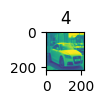

1 torch.Size([3, 220, 220]) 2


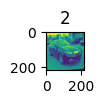

2 torch.Size([3, 220, 220]) 13


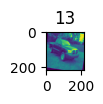

3 torch.Size([3, 220, 220]) 23


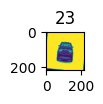

4 torch.Size([3, 220, 220]) 18


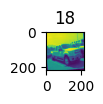

5 torch.Size([3, 220, 220]) 20


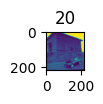

6 torch.Size([3, 220, 220]) 13


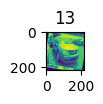

7 torch.Size([3, 220, 220]) 13


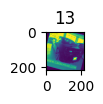

8 torch.Size([3, 220, 220]) 36


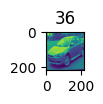

9 torch.Size([3, 220, 220]) 10


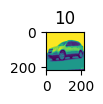

10 torch.Size([3, 220, 220]) 8


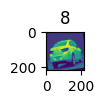

In [4]:
train_tfms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
                         v2.Resize((220, 220)),
                         v2.RandomHorizontalFlip(),
                         v2.RandomRotation(15),
                         v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_data = CarDataSet(csv_file="/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/train_make.csv",
                        root_dir="/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/images/train",
                        transform=train_tfms)
for i, data in enumerate(train_data):
    print(i, data[0].shape, data[1])

    ax = plt.subplot(1, 11, i + 1)
    plt.imshow(data[0][2])
    plt.title(data[1])
    plt.show()

    if i == 10:

        break

In [5]:
# Apply Data transform
# https://www.kaggle.com/code/deepbear/pytorch-car-classifier-90-accuracy
train_tfms = v2.Compose([v2.ToTensor(),
                         v2.Resize((200, 200)),
                         v2.RandomHorizontalFlip(),
                         v2.RandomRotation(15),
                         v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = v2.Compose([v2.ToTensor(),
                        v2.Resize((200, 200)),
                        v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the Data
train_data = CarDataSet(csv_file="/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/train_make.csv",
                        root_dir="/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/images/train",
                        transform=train_tfms)
test_data = CarDataSet(csv_file="/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/val_make.csv",
                       root_dir="/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/images/val",
                       transform=test_tfms)
batch_size = 16

# Import to Dataloaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers=2)

labels = open("/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/names_make.txt", 'r').read().split('\n')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## 2) Define your Model Architecture

It is up to you to decide which model you use. You can create yor own CNN or use transfer learning.

In [10]:
# Model definition
import torch
import torch.nn as nn

class VeryLargeWidthCNN(nn.Module):
    def __init__(self):
        super(VeryLargeWidthCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Assuming the input image size is 200x200, the feature map size would be 22x22 at this point
        self.fc1 = nn.Linear(in_features=67712, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=50)  # 10 classes for output

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output for fully connected layer
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Instantiate the model


very_large_width_cnn = VeryLargeWidthCNN()

# Move the model to GPU if available, else to CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
very_large_width_cnn.to(device)

# Print the model architecture
print(very_large_width_cnn)


VeryLargeWidthCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=67712, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=50, bias=True)
)


## 3) Define Loss function and Optimizer

You chose the loss function and optimizer.

In [11]:
num_classes = len(labels)
num_epochs = 15
lr = 1e-3

# Loss Function
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(very_large_width_cnn.parameters(), lr=lr)  # Replace efficientnet_.parameters() with very_large_width_cnn.parameters()



## 4) Train your Network

In [12]:
def test_accuracy(model, test_loader, device):
    model.to(device)
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return (100 * correct / total)

def partial_test_accuracy(model, test_loader, device, loss_fn):
    model.to(device)
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        i = 0
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = loss_fn(outputs, labels)
            losses.append(loss.item())
            i += 1
            if i % 100 == 0:
                break
    return (100 * correct / total), sum(losses) / len(losses)

def train(model, loss_fn, optimizer, train_loader, test_loader, batch_size, num_epochs, device):
    losses = []
    train_accs = []
    test_accs = []
    val_losses = []

    epoch_loss = []
    start_time = time.time()
    for epoch in range(num_epochs):
        # Iterate through the training dataset
        for i, data in enumerate(train_loader, 0):
            # Load images and labels and move them to the device
            images, labels = data[0].to(device), data[1].to(device)
            # Zero out any gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_fn(outputs, labels)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Print statistics every 100 iterations
            epoch_loss.append(loss.item())
            if (i+1) % 50 == 0:
                print(f"Step: [{i+1}/{len(train_loader)}]")


        end_time = time.time()
        loss = sum(epoch_loss) / len(epoch_loss)
        train_acc, _ = partial_test_accuracy(model, train_loader, device, loss_fn)
        test_acc, val_loss = partial_test_accuracy(model, test_loader, device, loss_fn)
        losses.append(loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print('Epoch [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}, Runtime: {:.4f} s'
                        .format(epoch+1, num_epochs, loss, val_loss, train_acc, test_acc, end_time - start_time))

        epoch_loss = []
        start_time = time.time()

        epoch_axis = np.linspace(0, epoch, len(losses))
        plot_learning_curve(epoch_axis, losses, val_losses, train_accs, test_accs, title=f"Epoch {epoch+1}")
    return losses, val_losses, train_accs, test_accs

def plot_learning_curve(epochs, losses, val_losses, train_accs, test_accs, title=''):
    plt.plot(epochs, losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + " Loss")
    plt.legend()
    plt.show()

    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, test_accs, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(title + " Accuracies")
    plt.legend()
    plt.show()

In [13]:
# Train Network
losses, val_losses, train_accs, test_accs = train(
    model=very_large_width_cnn,  # Replace efficientnet_b1 with very_large_width_cnn
    loss_fn=loss_function,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader,
    batch_size=batch_size,
    num_epochs=num_epochs,
    device=device
)
epochs = np.linspace(0, num_epochs, len(losses))

plot_learning_curve(epochs, losses, val_losses, train_accs, test_accs, title="128cnn")
print(test_accuracy(very_large_width_cnn, test_loader, device))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Step: [50/509]
Step: [100/509]
Step: [150/509]
Step: [200/509]
Step: [250/509]
Step: [300/509]
Step: [350/509]
Step: [400/509]
Step: [450/509]
Step: [500/509]


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

RuntimeError: ignored

In [ ]:
def train_next_stage(model, loss_fn, optimizer, train_loader, test_loader, batch_size, num_epochs, device, start_epoch=0):
    losses = []
    train_accs = []
    test_accs = []
    val_losses = []

    epoch_loss = []
    start_time = time.time()
    for epoch in range(start_epoch, num_epochs):
        # Iterate through the training dataset
        for i, data in enumerate(train_loader, 0):
            # Load images and labels and move them to the device
            images, labels = data[0].to(device), data[1].to(device)
            # Zero out any gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_fn(outputs, labels)

            # Backward pass
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Print statistics every 100 iterations
            epoch_loss.append(loss.item())
            if (i+1) % 50 == 0:
                print(f"Step: [{i+1}/{len(train_loader)}]")


        end_time = time.time()
        loss = sum(epoch_loss) / len(epoch_loss)
        train_acc, _ = partial_test_accuracy(model, train_loader, device, loss_fn)
        test_acc, val_loss = partial_test_accuracy(model, test_loader, device, loss_fn)
        losses.append(loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print('Epoch [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}, Runtime: {:.4f} s'
                        .format(epoch+1, num_epochs, loss, val_loss, train_acc, test_acc, end_time - start_time))

        epoch_loss = []
        start_time = time.time()

        epoch_axis = np.linspace(0, epoch, len(losses))
        plot_learning_curve(epoch_axis, losses, val_losses, train_accs, test_accs, title=f"Epoch {epoch+1}")
    return losses, val_losses, train_accs, test_accs

In [ ]:
losses_2, val_losses_2, train_accs_2, test_accs_2 = train_next_stage(model=resnet, loss_fn=loss_function, optimizer=optimizer, train_loader=train_loader, test_loader=test_loader,
               batch_size=batch_size, num_epochs=30, device=device, start_epoch=num_epochs)
losses.extend(losses_2)
val_losses.extend(val_losses_2)
train_accs.extend(train_accs_2)
test_accs.extend(test_accs_2)
epochs = np.linspace(0, num_epochs, len(losses))

plot_learning_curve(epochs, losses, val_losses, train_accs, test_accs, title="Resnet 50")
print(test_accuracy(resnet, test_loader, device))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Instantiate Pretrained ResNet18
'''
resnet18 = models.resnet18(pretrained=True)

# Modify final layer
resnet18.fc = nn.Linear(in_features=512, out_features=len(classes), bias=True)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# View Model to validate
print(resnet18)
'''

In [ ]:
# Train Network
'''
losses = train(model=resnet18, loss_fn=loss_function, optimizer=optimizer, train_loader=train_loader,
      batch_size=batch_size, num_epochs=num_epochs)
epochs = np.arange(1, num_epochs+1)

plot_learning_curve(epochs, losses)
plt.show()
'''

## 4) Evaluate (on Test Set)

In [ ]:
def test_accuracy(model, test_loader, input_size, device, is_conv=False):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].to(device), test_data[1].to(device)
            if not is_conv:
                images = images.view(-1, input_size)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy: %d %%' % (100 * correct / total))

In [ ]:
# Test Accuracy
test_accuracy(model=efficientnet, test_loader=test_loader, input_size=1000, device=device, is_conv=True)

In [ ]:
torch.save(efficientnet.state_dict(), "/content/drive/MyDrive/EEC 174 Lab3/stanford_cars_eec174/Efficientnet_weight.pth")

## 5) Report

Please write a report discussing all your choices and procedure to implement your vehicle classifier. In your report, include all your choices (i.e. hyperparameters, lr, models, loss, optimizer) and explain why you made those choices to achieve your performance. Your report must be thorough and comprehensive, please discuss fully how you were able to obtain a high performance.